# Application, Permit, Occupancy &mdash; NYC Build Time Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arrow
%matplotlib inline
pd.set_option("max_columns", 500)

In [2]:
data = pd.read_csv("../data/permit_occupancy_join_sample.csv", index_col=0)

## Permit-to-Occupancy Analysis

The sample of dates that we took consists of all borough-block-lots which recieved a construction permit in between April 25, 2013, when the open data record officially starts, and January 1, 2015, where our certificate of occupancy accessor algorithm ended its run. This means that every building has had at least 550 days in which to complete construction.

Because the open data trail ends at our starting point any further data that we might recover from running the algorithm further forward in time would be of decreasing utility and increasing incompleteness, because those buildings will have less and less time in which to complete before they no longer show up in our dataset.

Amongst the negative results we also have no way of distinguishing between cases in which a construction permit was filed for but the idea was eventually dropped, and cases where the construction permit was filed for and there has been progress of one form or another but the building still remains to be completed.

### Format conversions

Because we saved to `CSV` format all of the date variables need to be reloaded into `numpy` data forms.

First we convert dates. We need two date fields, `Issuance Date` (the date when the lot got its first new building permit, of format e.g. `06/21/2013 12:00:00 AM`) and `Certificate Date` (the date when the lot got its first certificate of occupancy, of format e.g. `06-21-2013`). Unfortunately I erronously encoded one set of dates in one format and the other set of dates in another, so each must be converted seperately in a slightly different way.

In [3]:
data.head(1)

,Unnamed: 0.1,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,Year,Certificate Date,Build Time
0,26416,BRONX,2818049.0,92,WEST TREMONT AVE,220177350.0,1.0,NB,NaN,2867.0,125.0,205,10453,2.0,YES,NaN,NaN,,ISSUED,INITIAL,NB,1.0,,,ON-SITE,2013-06-21,06/21/2013 12:00:00 AM,03/20/2014,06/21/2013,JIMMY,ZERVOUDIS,GALAXY G.C.GROUP LLC,7186017000,GENERAL CONTRACTOR,0610672,,,,,,,PHILIP ANTONAKOS,GALAXY GENERAL CONTRACTIO,HPD,Y,HOUSING PRESERVATION AND DEVELOP,TIMOTHY,JOSEPH,100,GOLD STREET,NEW YORK,NY,10038.0,2.128637e+09,06/22/2013 12:00:00 AM,2013,2015-11-02,864 days 00:00:00.000000000


In [4]:
def convert_issuance_time(date):
    if isinstance(date, float):
        return np.nan
    else:
        return np.datetime64(arrow.get(date.split(" ")[0], 'MM/DD/YYYY').datetime)
    
def convert_certificate_time(date):
    if isinstance(date, float):
        return np.nan
    else:
        return np.datetime64(arrow.get(date, 'YYYY-MM-DD').datetime)

In [5]:
data['Issuance Date'] = [convert_issuance_time(date) for date in data['Issuance Date']]
data['Certificate Date'] = [convert_certificate_time(date) for date in data['Certificate Date']]

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Then time deltas.

In [6]:
def convert_time_delta(delta):
    if isinstance(delta, float):
        return None
    else:
        return np.timedelta64(delta.split(" ")[0], 'D')

In [7]:
for col in ['Build Time']:
    data[col] = [convert_time_delta(delta) for delta in data[col]]

In [8]:
data.head(1)

,Unnamed: 0.1,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,Year,Certificate Date,Build Time
0,26416,BRONX,2818049.0,92,WEST TREMONT AVE,220177350.0,1.0,NB,NaN,2867.0,125.0,205,10453,2.0,YES,NaN,NaN,,ISSUED,INITIAL,NB,1.0,,,ON-SITE,2013-06-21,2013-06-21,03/20/2014,06/21/2013,JIMMY,ZERVOUDIS,GALAXY G.C.GROUP LLC,7186017000,GENERAL CONTRACTOR,0610672,,,,,,,PHILIP ANTONAKOS,GALAXY GENERAL CONTRACTIO,HPD,Y,HOUSING PRESERVATION AND DEVELOP,TIMOTHY,JOSEPH,100,GOLD STREET,NEW YORK,NY,10038.0,2.128637e+09,06/22/2013 12:00:00 AM,2013,2015-11-02,864 days


In a handful of cases the Build Time parameter come back as negative. We will throw those few cases out.

In [9]:
data = data[((data['Build Time'].isnull()) | (data['Build Time'] > np.timedelta64(0, "D")))]

### Key Variables  and Opening Thoughts

The key variables of interest are:

* `Issuance Date` &mdash; The date that the first construction permit was issued.
* `Certificate Date` &mdash; The date that the first certificate of occupancy was issued.
* `Build Time` &mdash; The time between the first building permit and the first certificate of occupancy.

Because the data in question is time-series data it is important to think about whether we can interpret it in terms of the overall statistics or must do so in terms of the statistics from the frame of reference of the date. We expect buildings started in 2013 to complete more often, in this dataset, than ones started in 2014, and so on down the line. The question is whether or not that effect is significant.

We will split the work between build timing and application timing.

First, the naive timing histogram.

### Naive Histogram

First, the naive timing histogram.

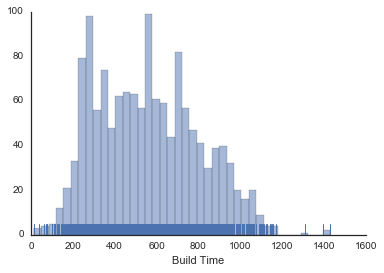

In [10]:
sns.set_style('white')
sns.distplot(data[data['Build Time'].notnull()]['Build Time'].map(lambda x: x.days),
             bins=40,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()

We see that a great part of the completes occur after 550 days, indicating that great care must be taken not interpret naive results.

The significant spikes are, on examination, batch job submissions.

Per below, about 23 percent of buildings complete before our minimum window time, 22 percent after, and 57 percent do not complete at all. Again this is strong evidence that our data is strongly time-dependent.

In [11]:
float(len(data[(data['Build Time'] > np.timedelta64("550", "D"))])) / float(len(data))

0.21696931747025675

In [12]:
float(len(data[(data['Build Time'].isnull())])) / float(len(data))

0.5660613650594866

### Time-series model

So instead we need to iteratively model a cumulative sum.

Ask the following question: given the buildings that per our dataset could still legally finish in time period X, what percentage of those buildings actually did complete? As we get further and further away this value becomes more speculative, but given that the average month contains ~80 new buildings I expect the error to remain relatively low. 

An explicit error bound will also be calculated (**TODO**).

The steps for this algorithm are:

1. Create a list of possible monthly timedeltas. Iterate through them.
2. Let $B=b$ — Lots built in timedelta $b$

   Let $E\geq b$ — Lots elegible to be built in timedelta $b$ (in our timeframe)
   
   For each timedelta $b$, count the number of buildings which were elegible to be built, $E$, and the number of buildings which were actually built, $B$.
3. Then $B/E$ will be the probability density function for that monthly period $b$.

In [13]:
sample_months = np.arange(np.datetime64('2013-04'), np.datetime64('2016-06'), step=np.timedelta64(1,'M'))
sample_timedeltas = sample_months - np.datetime64('2013-04')

In [14]:
# np.max(data['Issuance Date'])

In [15]:
# Capture buildings which were completed (for arithmatic purposes, since numpy doesn't like NaN arithmetic).
completed_buildings = data[data['Build Time'].notnull()]
# Set up the cumsum list.
# cumsum = [1]
# Set up the CDF holder.
cdf = [0]
pdf = [0]
num_observations = np.array([])

# Timedelta is a staggered list of all completion times that we could possibly have data on.
# Timedelta starts at 0 months.
# Each time we build a "window" of timedelta-to-timedelta-plus-one months.
# And squeeze what's in between.
for timedelta in sample_timedeltas:
    # Generate a list of all lots which *could* have been completed in timedelta months.
    # Two conditions:
    # 1. Given our timeframe, they could have been built in timedelta months.
#   # 2. They were not built earlier.
    elegible_lots = data[data['Issuance Date'] < np.datetime64('2016-07') - timedelta]
#     elegible_lots = elegible_lots[(elegible_lots['Build Time'].isnull()) | (elegible_lots['Build Time'] > timedelta)]
    # Capture that number.
    elegible_count = len(elegible_lots)
    num_observations = np.append(num_observations, [elegible_count])
    # Of these lots, capture which ones which *WERE* completed in one more month.
    completed_lots = elegible_lots[(elegible_lots['Build Time'].notnull()) &
                                   (elegible_lots['Build Time'] < timedelta + np.timedelta64(1, 'M')) &
                                   (elegible_lots['Build Time'] > timedelta)]
    # Capture that number.
    completed_count = len(completed_lots)
    # A = completed = # of lots completed in month X.
    # B = elegible = # of lots which could be completed in month X.
    # A / B = P(A|B) = P(completed|elegible)
    completed_given_elegible = completed_count / float(elegible_count)
    pdf.append(completed_given_elegible)
    print(completed_count, elegible_count, completed_given_elegible)
#     cdf.append(cdf[-1] + (1 - cdf[-1]) * completed_given_elegible)
#     # 1 minus the ratio between these two values is the survival function.
#     # That is, it is the percent chance that a building which has not recieved a C of O in X months will not
#     # recieve a C of O in X+1 months either.
#     survival_rate = 1 - completed_count / float(elegible_count)
#     # Use that to calculate the effect on the survival CDF and append that to the list.
#     cumsum.append(cumsum[-1] * survival_rate)

pdf = np.array(pdf)
cdf = pdf.cumsum()

# Invert the survival cumulative to get the discrete by-month permit-to-occupancy CDF.
# cdf = 1 - np.array(cumsum)
# Subtract through to get the PDF.
# cdf = np.array(cdf)
# pdf = cdf[1:] - cdf[:-1]
# Include the largely symbolic first value into the PDF
# pdf = np.insert(pdf, 0, 0)

del completed_buildings

(2, 3194, 0.0006261740763932373)
(1, 3194, 0.00031308703819661864)
(4, 3194, 0.0012523481527864746)
(5, 3194, 0.0015654351909830933)
(11, 3194, 0.0034439574201628053)
(12, 3193, 0.003758221108675227)
(27, 3192, 0.008458646616541353)
(56, 3192, 0.017543859649122806)
(80, 3192, 0.02506265664160401)
(70, 3192, 0.021929824561403508)
(46, 3190, 0.014420062695924765)
(67, 3190, 0.021003134796238245)
(37, 3189, 0.011602383192223268)
(51, 3187, 0.016002510197678066)
(64, 3185, 0.020094191522762952)
(52, 3180, 0.016352201257861635)
(54, 3178, 0.016991818753933293)
(51, 3176, 0.01605793450881612)
(88, 3165, 0.027804107424960506)
(49, 2983, 0.016426416359369762)
(59, 2890, 0.02041522491349481)
(40, 2736, 0.014619883040935672)
(41, 2494, 0.01643945469125902)
(78, 2330, 0.03347639484978541)
(38, 2193, 0.017327861377108983)
(43, 2060, 0.02087378640776699)
(36, 1908, 0.018867924528301886)
(28, 1741, 0.016082711085583)
(31, 1535, 0.020195439739413682)
(26, 1427, 0.018220042046250877)
(37, 1301, 0.0284

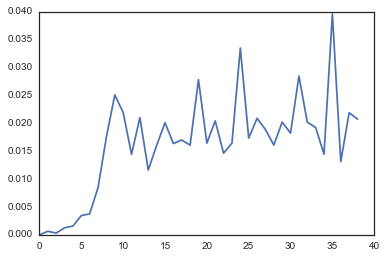

In [16]:
plt.plot(pdf)

Extrordinarily, it appears that after an initial lag period (and accounting for the volatility of the dataset) the rate of building construction (in the captured timeframe) is *linear* with respect to time.

This is very surprising. I expected building construction times to be approximately normally distributed, which they clearly aren't.

Below I do a monthly breakdown.

In [17]:
# I accidentally deleted gen_cdf_pdf.

In [19]:
# monthly_dfs = [data[data['Issuance Date'].map(lambda d: (d.month == n) & (d.year == 2014))] for n in range(1, 13)]
# for n in range(0, 12):
#     cdf, pdf = gen_cdf_pdf(monthly_dfs[n])
#     plt.plot(pdf)

In [20]:
# monthly_dfs = [data[data['Issuance Date'].map(lambda d: (d.month == n) & (d.year == 2013))] for n in range(1, 13)]
# for n in range(0, 12):
#     cdf, pdf = gen_cdf_pdf(monthly_dfs[n])
#     plt.plot(pdf)

The CDF makes things clearer.

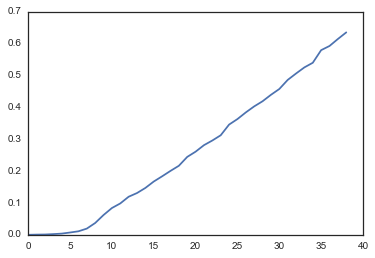

In [21]:
plt.plot(cdf)

Again we see a linear construction rate with respect to time. The plot can be broken down into two parts: the initial lag, and the linear growth period.

But this is because we are limited by our dataset in our observations to just the first 37 months or so. The curve will have to round off at some point, creating another flatter portion of the curve somewhere in the 40-month-plus range.

If knew what the overall percentage of permits which result in new buildings (that is, permits which are not abandoned) are, then we could extrapolate the end of the curve. However, because we don't know what the cealing is, we can't do that.

More data would be helpful in interpreting this result. The following plot charts the number of observations each pass is based on.

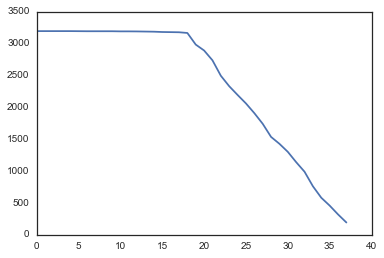

In [22]:
plt.plot(num_observations)

An average build time is not a meaningful statistic. Averages would fail to capture the structure of the data very well, due to its linear nature.

We do have data up to the ~60th percentile, however. So we do have and can use a meaningful median value (though not a full IQR), and speak to the challenges of getting a more accurate depiction.

## Application-to-Permit Analysis

In [34]:
p_data = pd.read_csv("../data/application_permit_join_sample.csv", index_col=0)

The challenge is again the same: how do we account for the limitation on the time frame of our data? In this case I took all of the permit data between July 2016 and the beginning of 2015, and merged the job data onto that. Since the job data goes back to March 2013, this means that every permit had the opportunity for a year and a half of application acrrual ahead of getting an actual permit.

### Format conversions

Again we have to fix inputs first.

In [48]:
# def convert_issuance_time(date):
#     if isinstance(date, float):
#         return np.nan
#     else:
#         return np.datetime64(arrow.get(date, 'MM/DD/YYYY').datetime)
    
def convert_issuance_and_application_time(date):
    if isinstance(date, float):
        return np.nan
    else:
        return np.datetime64(arrow.get(date, 'YYYY-MM-DD').datetime)

In [42]:
p_data['Issuance Date'] = [convert_issuance_and_application_time(date) for date in p_data['Issuance Date']]

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [50]:
p_data['Application Date'] = [convert_issuance_and_application_time(date) for date in  p_data['Application Date']]

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [51]:
for col in ['Application Time']:
    p_data[col] = [convert_time_delta(delta) for delta in p_data[col]]

### Naive histogram

Again we start by looking at a naive, time window -ignoring histogram.

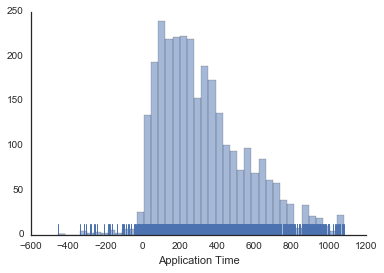

In [52]:
sns.set_style('white')
sns.distplot(p_data[p_data['Application Time'].notnull()]['Application Time'].map(lambda x: x.days),
             bins=40,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()

The problem is the same, a very non-trivial amount of information is getting cut off. I did two ways:

1. Adapting the script above directly.
2. Independently rewriting the script above from a functional perspective.

### Functional Time-Series Analysis

In [53]:
from datetime import datetime

In [54]:
def legal_observations(df, time_col, timedelta):
    """
    Given a DataFrame of times and a certain timedelta input, returns the observations in the time series which are more
    than timedelta from the present (said another way, the observations whose outcomes have been observed in the given
    timedelta).
    """
    now = np.datetime64(datetime.now())
    most_recent_possible_date = np.datetime64('2016-07') - timedelta
    # print(most_recent_possible_date)
    df = df[df[time_col].notnull()]
    return df[df[time_col].map(lambda t: t < most_recent_possible_date)]


def count_legal_observations(df, time_col, timedelta):
    """
    Counter wrapper for `legal_observations()`.
    """
    return len(legal_observations(df, time_col, timedelta))


def bounded_timedelta_observations(df, timedelta_col, (minimum_timedelta, maximum_timedelta)):
    """
    Gets DataFrames indices with timedeltas present in some column which are between two bounds.
    """
    df = df[df[timedelta_col].notnull()]
    return df[(df[timedelta_col] < maximum_timedelta) & (df[timedelta_col] > minimum_timedelta)]


def count_bounded_timedelta_observations(df, timedelta_col, (minimum_timedelta, maximum_timedelta)):
    """
    Counter wrapper for `legal_observations()`.
    """
    return len(bounded_timedelta_observations(df, timedelta_col, (minimum_timedelta, maximum_timedelta)))

In [55]:
num_observations = []
application_time_pdf = []
num_successes = []

for n in range(1, 39):
    observations = legal_observations(p_data, 'Application Date', np.timedelta64(n, 'M'))
    num_observations.append(len(observations))
#     if n == 24:
#         test_set = observations
    count_successes = count_bounded_timedelta_observations(
        observations,
        'Application Time',
        (np.timedelta64(n - 1, 'M'), np.timedelta64(n, 'M'))
    )
    num_successes.append(count_successes)

# application_time_pdf = np.array(num_observations) / len(p_data)
# application_time_cdf = application_time_pdf.cumsum()

In [69]:
application_time_pdf = np.array(num_successes) / np.array(num_observations).astype(float)
application_time_cdf = application_time_pdf.cumsum()

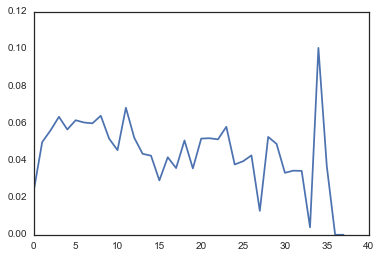

In [68]:
plt.plot(application_time_pdf)

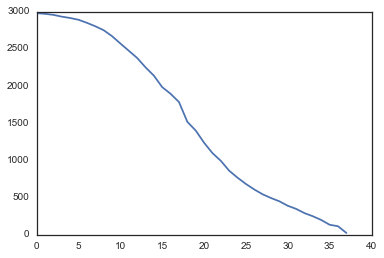

In [64]:
plt.plot(num_observations)

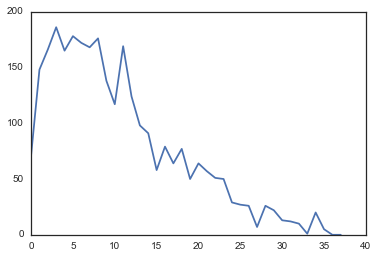

In [65]:
plt.plot(num_successes)

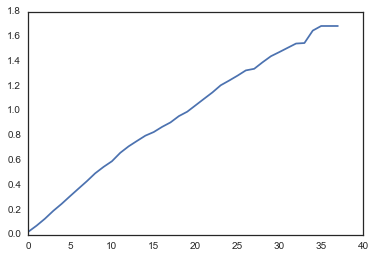

In [70]:
plt.plot(application_time_cdf)

### Scripted Time-Series Analysis

In [ ]:
permitted_buildings = p_data[p_data['Application Time'].notnull()]
# Set up the cumsum list.
# cumsum = [1]
# Set up the CDF holder.
cdf = [0]
pdf = [0]
num_observations = np.array([])

# Timedelta is a staggered list of all completion times that we could possibly have data on.
# Timedelta starts at 0 months.
# Each time we build a "window" of timedelta-to-timedelta-plus-one months.
# And squeeze what's in between.
for timedelta in sample_timedeltas:
    # Generate a list of all lots which *could* have been completed in timedelta months.
    # Two conditions:
    # 1. Given our timeframe, they could have been built in timedelta months.
#   # 2. They were not built earlier.
    elegible_lots = p_data[p_data['Application Date'] < np.datetime64('2016-07') - timedelta]
#     elegible_lots = elegible_lots[(elegible_lots['Build Time'].isnull()) | (elegible_lots['Build Time'] > timedelta)]
    # Capture that number.
    elegible_count = len(elegible_lots)
    num_observations = np.append(num_observations, [elegible_count])
    # Of these lots, capture which ones which *WERE* completed in one more month.
    permitted_lots = elegible_lots[(elegible_lots['Application Time'].notnull()) &
                                   (elegible_lots['Application Time'] < timedelta + np.timedelta64(1, 'M')) &
                                   (elegible_lots['Application Time'] > timedelta)]
    # Capture that number.
    permitted_count = len(permitted_lots)
    # A = completed = # of lots completed in month X.
    # B = elegible = # of lots which could be completed in month X.
    # A / B = P(A|B) = P(completed|elegible)
    permitted_given_elegible = permitted_count / float(elegible_count)
    pdf.append(permitted_given_elegible)
    print(permitted_count, elegible_count, permitted_given_elegible)
#     cdf.append(cdf[-1] + (1 - cdf[-1]) * completed_given_elegible)
#     # 1 minus the ratio between these two values is the survival function.
#     # That is, it is the percent chance that a building which has not recieved a C of O in X months will not
#     # recieve a C of O in X+1 months either.
#     survival_rate = 1 - completed_count / float(elegible_count)
#     # Use that to calculate the effect on the survival CDF and append that to the list.
#     cumsum.append(cumsum[-1] * survival_rate)

pdf = np.array(pdf)
cdf = pdf.cumsum()

# Invert the survival cumulative to get the discrete by-month permit-to-occupancy CDF.
# cdf = 1 - np.array(cumsum)
# Subtract through to get the PDF.
# cdf = np.array(cdf)
# pdf = cdf[1:] - cdf[:-1]
# Include the largely symbolic first value into the PDF
# pdf = np.insert(pdf, 0, 0)

del permitted_buildings

In [60]:
cdf

array([  0.00000000e+00,   6.26174076e-04,   9.39261115e-04,
         2.19160927e-03,   3.75704446e-03,   7.20100188e-03,
         1.09592230e-02,   1.94178696e-02,   3.69617293e-02,
         6.20243859e-02,   8.39542105e-02,   9.83742732e-02,
         1.19377408e-01,   1.30979791e-01,   1.46982301e-01,
         1.67076493e-01,   1.83428694e-01,   2.00420513e-01,
         2.16478447e-01,   2.44282555e-01,   2.60708971e-01,
         2.81124196e-01,   2.95744079e-01,   3.12183534e-01,
         3.45659929e-01,   3.62987790e-01,   3.83861576e-01,
         4.02729501e-01,   4.18812212e-01,   4.39007652e-01,
         4.57227694e-01,   4.85667356e-01,   5.05860508e-01,
         5.25071832e-01,   5.39526497e-01,   5.79113416e-01,
         5.92213853e-01,   6.14088853e-01,   6.34814241e-01])

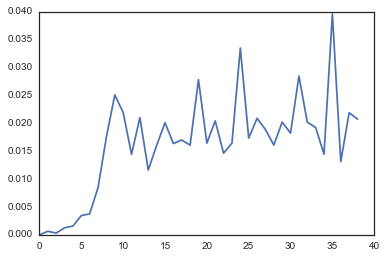

In [61]:
plt.plot(pdf)

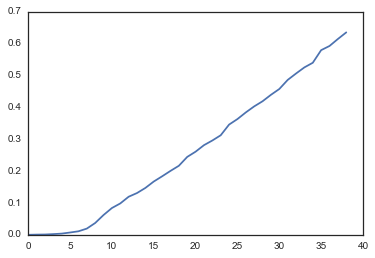

In [62]:
plt.plot(cdf)

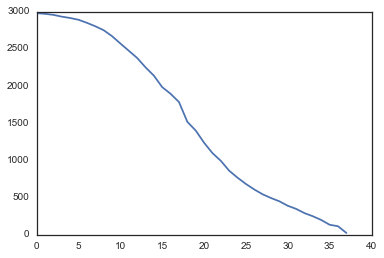

In [63]:
plt.plot(num_observations)

Both of these attempts show the same thing, something pattently wrong&mdash;a CDF way over 1. That closes the book on the wrongness of this approach, unfortunately.

So the real lesson learned here is that it's time for me to learn proper time series analysis techniques.